# 0_数据准备
本notebook主要介绍如何获取数据，为后续的指标计算和策略实现做准备。

### 1. 数据来源介绍
获取行情数据的常用方法有以下几种：

1. Tushare：专注于金融数据的开源Python库，提供基础的股票、基金、期货、期权等金融数据
2. AKShare：另一个开源金融数据接口库，涵盖金融、经济、特色数据等
3. Alpha Vantage：全球股票（美股、港股、A股部分支持，但 A 股数据不如 tushare 全面）、ETF、外汇、加密货币
4. Yahoo Finance：全球股票（美股、港股、A股部分支持，但 A 股数据不如 tushare 全面）、ETF、外汇、加密货币
这里以Tushare为例，展示如何获取A股股票的历史行情数据。

### 2. 安装并配置所依赖的库Tushare，yfinance

In [3]:
# 安装Tushare（如果尚未安装）
# !pip install tushare# 

In [3]:
# 导入必要的库
import tushare as ts
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import warnings
import os
from dotenv import load_dotenv, find_dotenv

# Find the .env file in the parent directory
dotenv_path = find_dotenv("../.env") 

if not dotenv_path:
    print("未找到 .env 文件，请确保 .env 文件存在")
else:
    load_dotenv(dotenv_path)
    print("成功加载 .env 文件")


# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)  
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')  
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False 

成功加载 .env 文件


In [5]:
# 设置Tushare的Token（需要先在Tushare官网注册获取）
# 请在此处替换为您自己的Token
ts.set_token(os.getenv("TUSHARE_API_TOKEN"))  
pro = ts.pro_api()

### 3. 获取A股股票列表

In [31]:
# 获取股票列表
stock_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date') 
stock_list.head()  

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,000001,平安银行,深圳,银行,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,19910129
2,000004.SZ,000004,*ST国华,深圳,软件服务,19910114
3,000006.SZ,000006,深振业A,深圳,区域地产,19920427
4,000007.SZ,000007,全新好,深圳,其他商业,19920413


In [10]:
pd.reset_option('display.max_rows')

### 4. 获取个股历史行情数据
我们选择几支具有代表性的A股股票，获取它们的历史日线数据。

In [21]:
# 设置时间范围
start_date = '20200101'  
end_date = '20230101'  

# 选择几支代表性股票的代码
# 宁德时代 - 新能源龙头
# 贵州茅台 - 白酒龙头
# 中国平安 - 保险龙头
stock_codes = ['300750.SZ', '600519.SH', '601318.SH']  
stock_names = ['宁德时代', '贵州茅台', '中国平安'] 

In [22]:
# 函数：获取单只股票的历史数据
def get_stock_data(ts_code, start_date, end_date): 
    df = pro.daily(ts_code=ts_code, start_date=start_date, end_date=end_date)  
    # 按日期升序排列
    df = df.sort_values('trade_date')
    # 将日期转换为datetime格式
    df['trade_date'] = pd.to_datetime(df['trade_date']) 
    # 设置日期为索引
    df.set_index('trade_date', inplace=True) 
    return df 

In [23]:
# 获取三只股票的数据并存储到字典中
stock_data = {}  

for i, code in enumerate(stock_codes):
    try:  
        stock_data[stock_names[i]] = get_stock_data(code, start_date, end_date) 
        print(f"成功获取 {stock_names[i]} 的历史数据")  
    except Exception as e:  
        print(f"获取 {stock_names[i]} 数据时出现错误: {e}")

成功获取 宁德时代 的历史数据
成功获取 贵州茅台 的历史数据
成功获取 中国平安 的历史数据


### 5. 数据预览与基本分析

In [25]:
# 查看平安银行的数据结构
stock_data['宁德时代'].head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2020-01-02,300750.SZ,107.21,108.85,105.70,107.52,106.40,1.12,1.0526,206115.89,2213454.650
2020-01-03,300750.SZ,107.52,110.19,105.97,109.55,107.52,2.03,1.8880,180841.78,1956828.808
2020-01-06,300750.SZ,111.30,114.50,107.80,109.09,109.55,-0.46,-0.4199,265002.00,2958351.779
2020-01-07,300750.SZ,109.01,109.64,107.41,108.50,109.09,-0.59,-0.5408,135075.44,1461154.189
2020-01-08,300750.SZ,109.01,111.50,107.10,109.60,108.50,1.10,1.0138,192240.68,2098374.347


In [26]:
# 查看数据基本统计信息
stock_data['宁德时代'].describe() 

,open,high,low,close,pre_close,change,pct_chg,vol,amount
count,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,7.280000e+02
mean,375.991690,384.111937,367.405783,375.923874,375.528091,0.395783,0.235540,169282.822596,5.865322e+06
std,157.594788,160.335782,153.906886,157.106192,157.421876,12.893920,3.340734,79082.848487,2.856742e+06
min,107.210000,108.850000,105.010000,107.480000,106.400000,-45.270000,-9.871300,54030.520000,1.308079e+06
25%,218.470000,223.962500,211.280000,222.070000,215.862500,-6.725000,-1.873200,116039.557500,3.839248e+06
50%,397.475000,406.025000,389.500000,397.030000,397.030000,0.005000,0.004150,149047.090000,5.438800e+06
75%,509.962500,520.395000,499.815000,508.532500,508.532500,6.470000,1.967450,197996.465000,7.547994e+06
max,688.960000,692.000000,673.330000,688.000000,688.000000,52.990000,15.092100,602772.070000,2.225553e+07


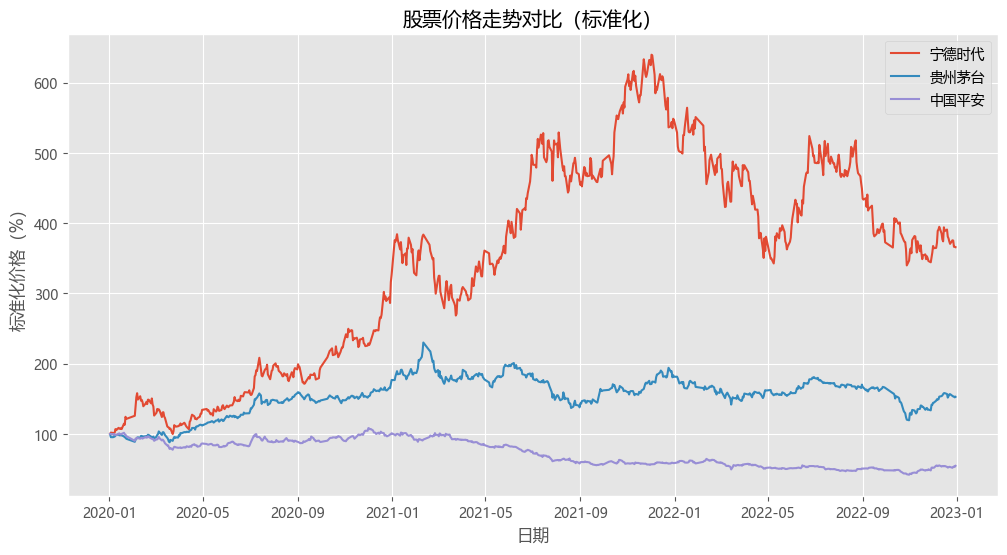

In [27]:
# 基本数据可视化
plt.figure(figsize=(12, 6)) 

for name, data in stock_data.items():  
    # 价格标准化，便于比较
    normalized_price = data['close'] / data['close'].iloc[0] * 100  
    plt.plot(data.index, normalized_price, label=name)  

plt.title('股票价格走势对比（标准化）')  
plt.xlabel('日期')  
plt.ylabel('标准化价格（%）')  
plt.legend() 
plt.grid(True) 
plt.show() 

### 6. 保存数据到CSV文件（可选）
将获取的数据保存到本地，以便后续使用。

In [28]:
# 创建保存数据的文件夹（如果不存在）
import os  
if not os.path.exists('data'):
    os.makedirs('data') 

In [29]:
# 保存数据到CSV文件
for name, data in stock_data.items():  
    file_path = f'data/{name}_data.csv'  
    data.to_csv(file_path)  
    print(f"已将{name}的数据保存到 {file_path}")

已将宁德时代的数据保存到 data/宁德时代_data.csv
已将贵州茅台的数据保存到 data/贵州茅台_data.csv
已将中国平安的数据保存到 data/中国平安_data.csv


### 7. 从CSV文件加载数据（可选）
如果已经有保存好的数据，可以直接从CSV文件中加载。

In [ ]:
# 从CSV文件加载数据
def load_data_from_csv(file_path):  
    df = pd.read_csv(file_path, index_col=0) 
    df.index = pd.to_datetime(df.index)  
    return df
    
# 示例：加载平安银行的数据
# pingan_data = load_data_from_csv('data/平安银行_data.csv')
# pingan_data.head()

### 总结
在本notebook中，我们完成了以下任务：

+ 安装并配置了Tushare数据接口
+ 获取了A股股票列表
+ 获取了三只代表性股票的历史行情数据
+ 对数据进行了基本的可视化和分析
+ 学习了如何保存和加载数据
这些数据将在后续的指标计算和策略实现中使用。

从yahoo_finance 下载特斯拉过去五年的数据